### Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord,skycoord_to_pixel
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from tqdm import tqdm,trange
import os
import matplotlib as mpl
import seaborn as sns
import pandas as pd

In [3]:
# path to general directory where data stored
path = '/Users/ncv375/Desktop/Year1/spatialSED/quick_repo_natalia'

### Initialize directories where data is stored

Answer input questions to navigate to correct directories

We use PSF-convolved, background-subtracted mosaics

In [5]:
def get_filenames_in_dir(directory):
    return [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

#load convolved images
inp_includehst = input("Choose to include HST/ACS filters (y) or not include (n): ")
if inp_includehst == "y":
    nircam_fp, nircam_err_fp = path+'/prepare_resolved_obs/jadesconvmosaics/', path+'/prepare_resolved_obs/nircam_dr2/'
    hudf_fp, hudf_err_fp = path+'/prepare_resolved_obs/jadesconvmosaics/', path+'/prepare_resolved_obs/hstacs_err/'
    nircam_mosaics=sorted(get_filenames_in_dir(path+'/prepare_resolved_obs/jadesconvmosaics/'))[6:]
    if nircam_mosaics[0]=='.DS_Store':
        nircam_mosaics = nircam_mosaics[1:]
    nircam_mosaics_err=sorted(get_filenames_in_dir(path+'/prepare_resolved_obs/nircam_dr2/'))
    hudf_mosaics=sorted(get_filenames_in_dir(path+'/prepare_resolved_obs/jadesconvmosaics/'))[:6]
    if hudf_mosaics[0]=='.DS_Store':
        hudf_mosaics = hudf_mosaics[1:]
    hudf_err=sorted(get_filenames_in_dir(path+'/prepare_resolved_obs/hstacs_err/'))
elif inp_includehst == "n":
    nircam_fp, nircam_err_fp = path+'/prepare_resolved_obs/jadesconvmosaics/', path+'/prepare_resolved_obs/nircam_dr2/'
    nircam_mosaics=sorted(get_filenames_in_dir(path+'/prepare_resolved_obs/jadesconvmosaics/'))
    if nircam_mosaics[0]=='.DS_Store':
        nircam_mosaics = nircam_mosaics[1:]
    nircam_mosaics_err=sorted(get_filenames_in_dir(path+'/prepare_resolved_obs/nircam_dr2/'))

### Set up cutouts

Designate region to cut out of mosaic, and organize cutouts per filter into one array for photometry and another for error

Start with JWST mosaics

0 jades_nrc_f090w_sci_matchf444w.fits
(110, 195)
(110, 195)


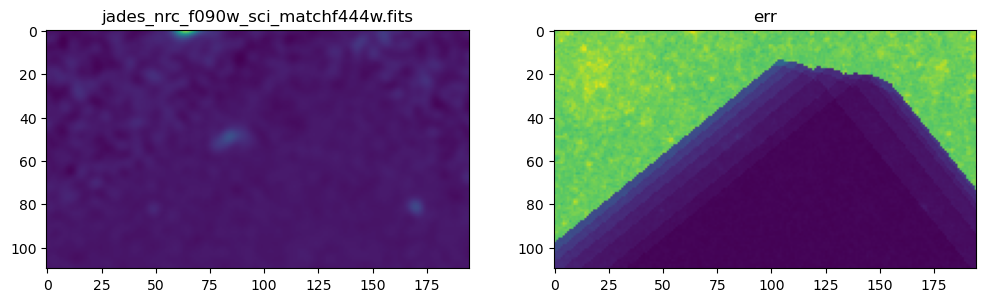

1 jades_nrc_f115w_sci_matchf444w.fits
(110, 195)
(110, 195)


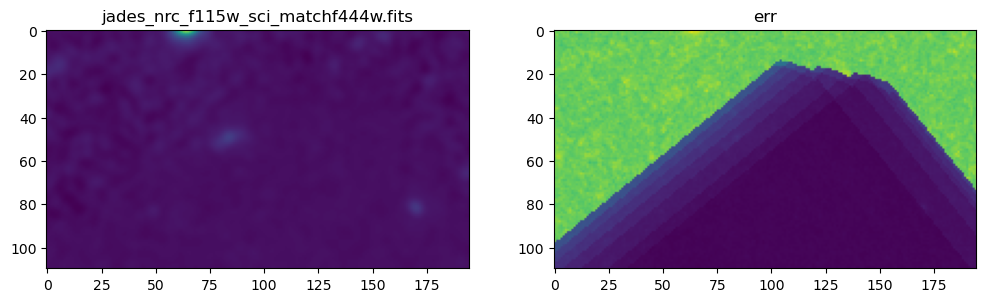

2 jades_nrc_f150w_sci_matchf444w.fits
(110, 195)
(110, 195)


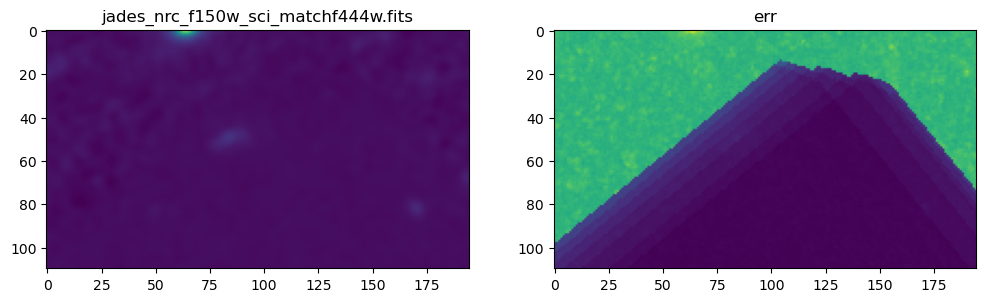

3 jades_nrc_f182m_sci_matchf444w.fits
(110, 195)
(110, 195)


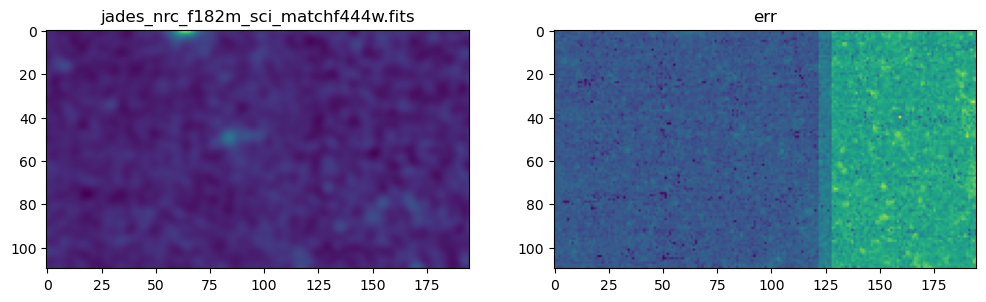

4 jades_nrc_f200w_sci_matchf444w.fits
(110, 195)
(110, 195)


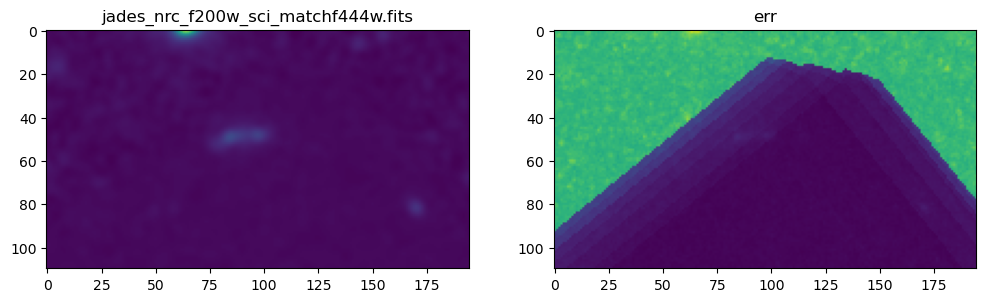

5 jades_nrc_f210m_sci_matchf444w.fits
(110, 195)
(110, 195)


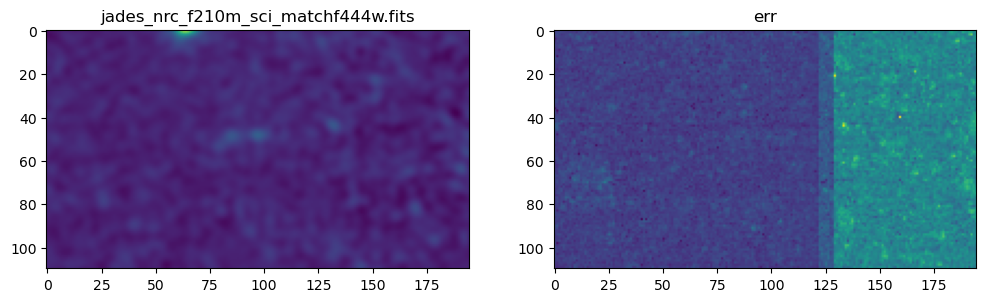

6 jades_nrc_f277w_sci_matchf444w.fits
(110, 195)
(110, 195)


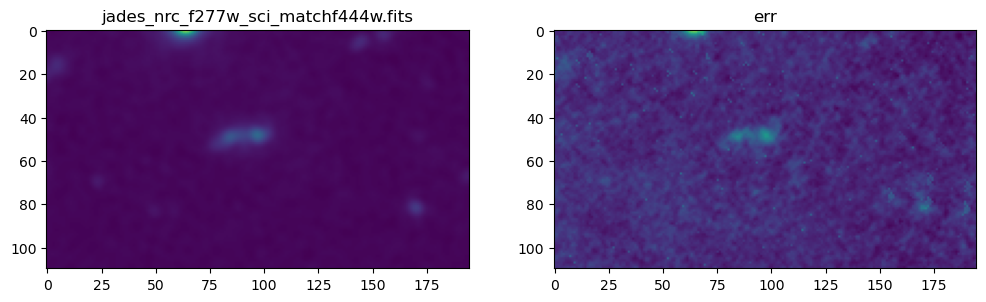

7 jades_nrc_f335m_sci_matchf444w.fits
(110, 195)
(110, 195)


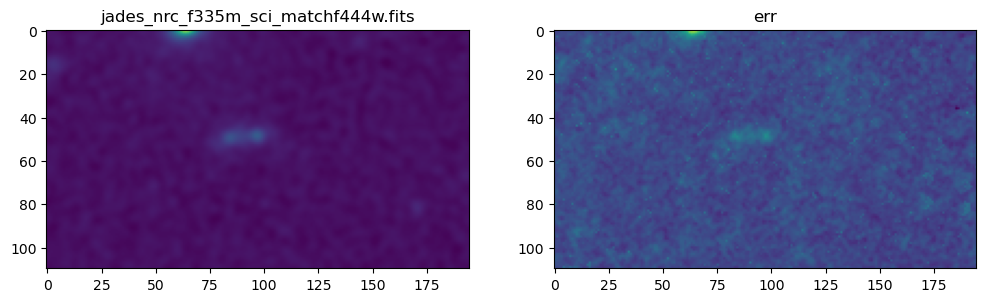

8 jades_nrc_f356w_sci_matchf444w.fits
(110, 195)
(110, 195)


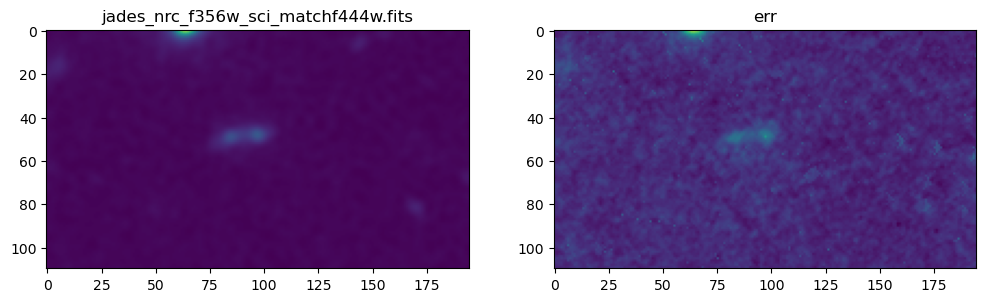

9 jades_nrc_f410m_sci_matchf444w.fits
(110, 195)
(110, 195)


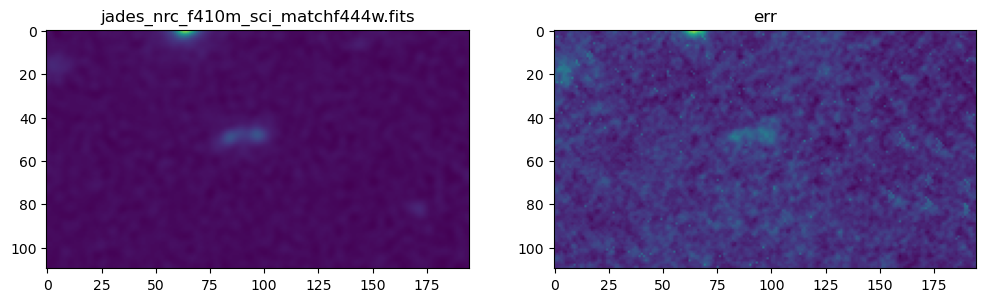

10 jades_nrc_f430m_sci_matchf444w.fits
(110, 195)
(110, 195)


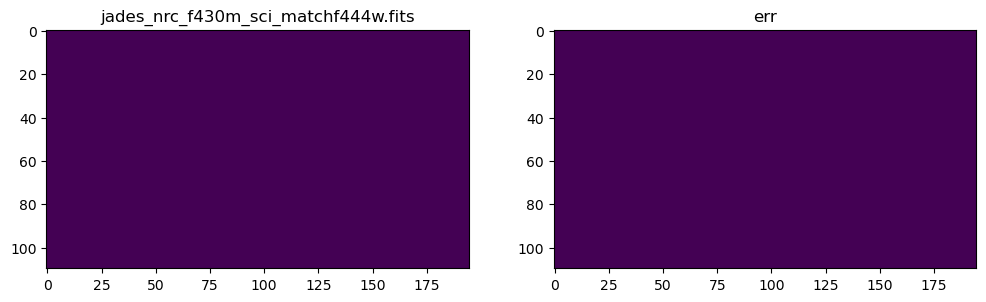

11 jades_nrc_f444w_sci_matchf444w.fits
(110, 195)
(110, 195)


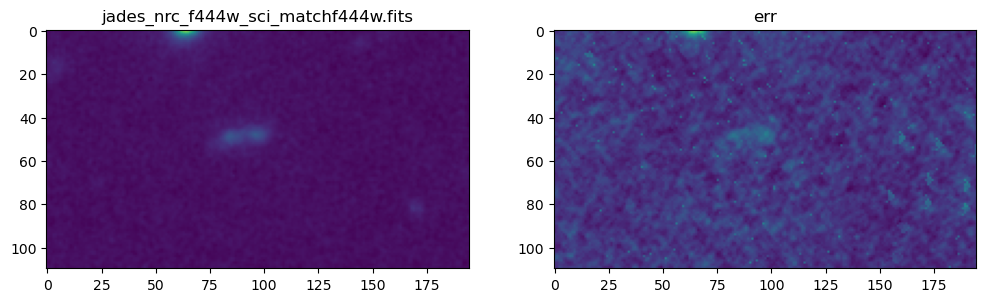

12 jades_nrc_f460m_sci_matchf444w.fits
(110, 195)
(110, 195)


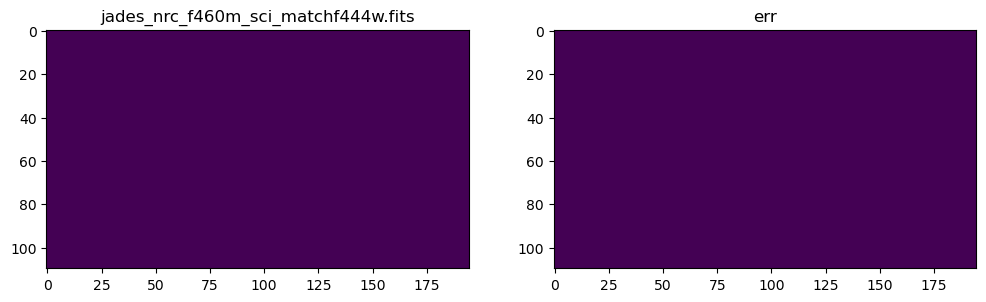

13 jades_nrc_f480m_sci_matchf444w.fits
(110, 195)
(110, 195)


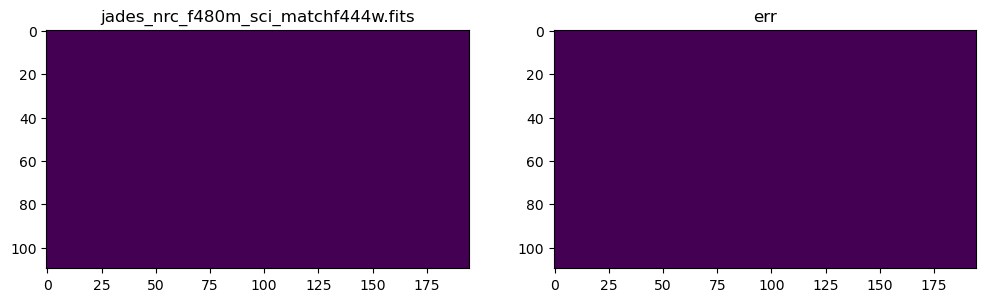

In [6]:
# all filters (default): f090w f115w f150w f182m f200w f210m f277w f335m f356w f410m f430m f444w f460m f480m_
# GSz14 region: 16054, 16249, 10684, 10794

# Define filters
inp_filterlist = input("Enter filter names you want to use, separated by space (format e.g. f200w, write last filter as fxxxy_). If you want to use all filters, type 'default': ")
if inp_filterlist == "default":
    filterlist = 'f090w f115w f150w f182m f200w f210m f277w f335m f356w f410m f430m f444w f460m f480m_'.split()
else:
    filterlist = inp_filterlist.split()
nircam_mosaics = [s for s in nircam_mosaics if any(xs in s for xs in filterlist)]

# Define region to cut out of mosaic
inp_segregion_xmin = int(input("Designate bounding region of segmentation map, xmin: "))
inp_segregion_xmax = int(input("xmax: "))
inp_segregion_ymin = int(input("ymin: "))
inp_segregion_ymax = int(input("ymax: "))

# Initialize arrays for photometry and error
phot_jades=np.zeros((len(filterlist)),dtype=object)
err_jades=np.zeros((len(filterlist)),dtype=object)
coords=np.zeros((1,2),dtype=object)

# Fill in arrays for each filter
# Show plot of photometry and error for each filter
for k,j in enumerate(nircam_mosaics[:]):
    print(k, j)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    hdul = fits.open(nircam_fp+j)
    hdul_err = fits.open(nircam_err_fp+nircam_mosaics_err[k])
    photo  = hdul[0].data[inp_segregion_ymin:inp_segregion_ymax, inp_segregion_xmin:inp_segregion_xmax]
    print(np.shape(photo))

    err= hdul_err[2].data[inp_segregion_ymin:inp_segregion_ymax, inp_segregion_xmin:inp_segregion_xmax]
    print(np.shape(err))

    ax1.imshow(photo)
    ax1.set_title(j)

    ax2.imshow(err)
    ax2.set_title('err')

    plt.show()

    if k==0:
        coords[0, 0] = np.where(photo != None)[0]
        coords[0, 1] = np.where(photo != None)[1]

    hdr = hdul_err[0].header['PIXAR_SR']

    PIXAR_SR= hdr
    photo=photo*PIXAR_SR*1e12 #microJy
    err=err*PIXAR_SR*1e12 #microJy

    phot_jades[k]=photo.flatten()
    err_jades[k]=err.flatten()

    hdul.close()
    hdul_err.close()

Now do HST mosaics

jades_acs_f435w_sci_matchf444w.fits
(110, 195)
(110, 195)


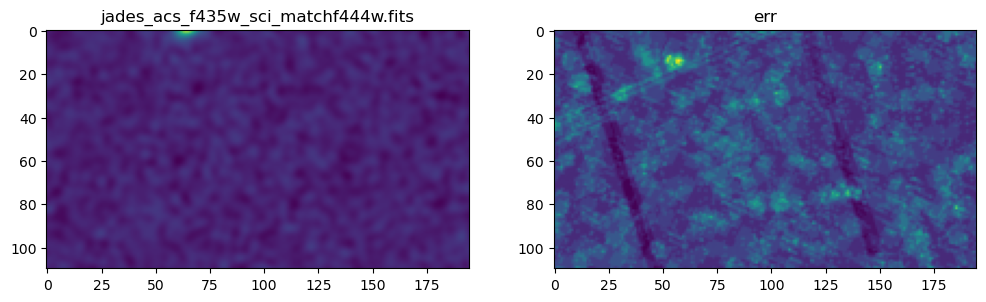

jades_acs_f606w_sci_matchf444w.fits
(110, 195)
(110, 195)


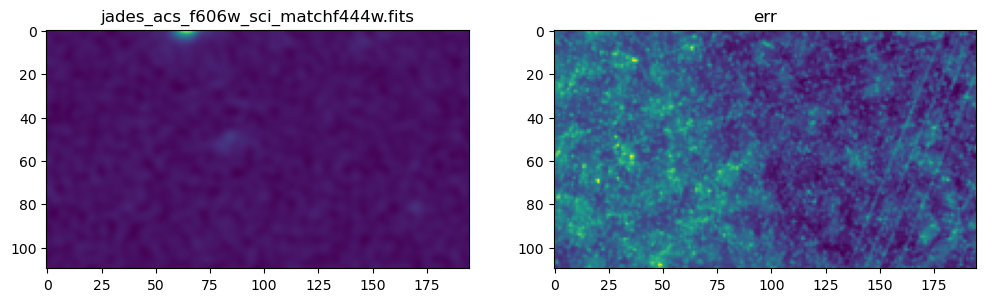

jades_acs_f775w_sci_matchf444w.fits
(110, 195)
(110, 195)


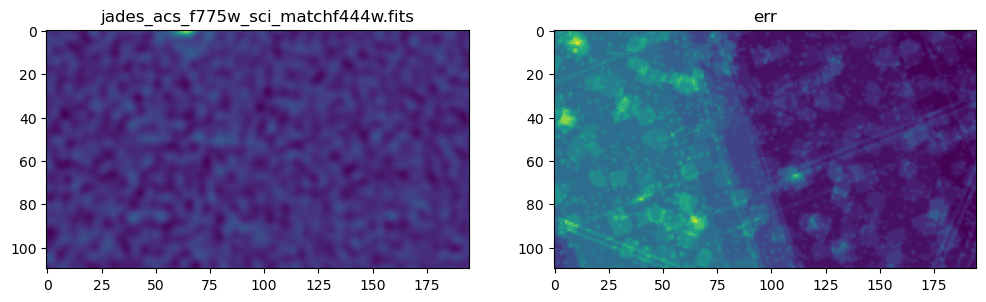

jades_acs_f814w_sci_matchf444w.fits
(110, 195)
(110, 195)


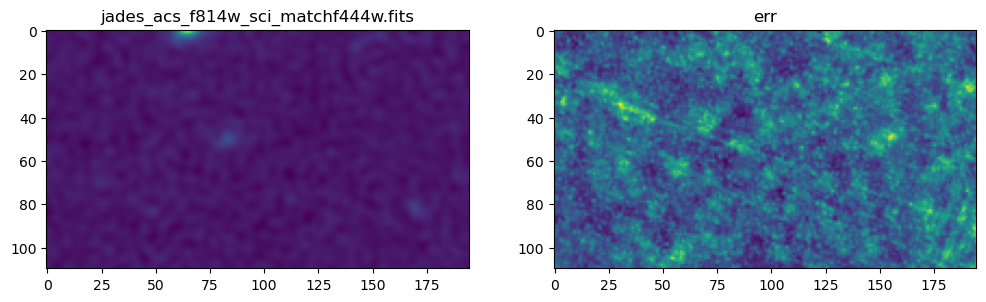

jades_acs_f850l_sci_matchf444w.fits
(110, 195)
(110, 195)


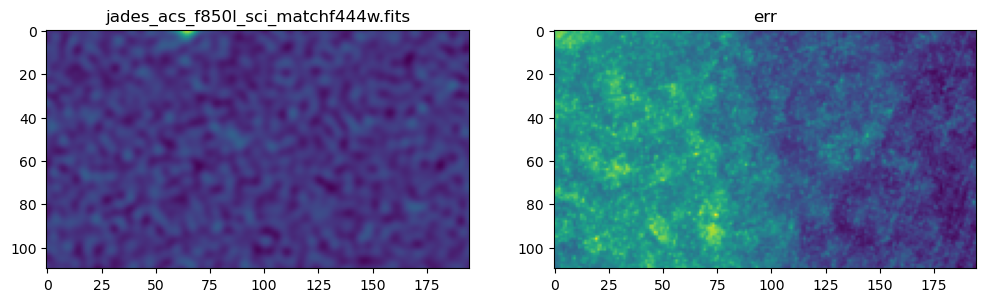

In [7]:
#Now with ACS

phot_acs=np.zeros(5,dtype=object)
err_acs=np.zeros(5,dtype=object)
#435,606,775,814,850

for k,j in enumerate(hudf_mosaics[:]):
    print(j)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    hdul = fits.open(hudf_fp+j)
    hdul_err = fits.open(hudf_err_fp+hudf_err[k])
    photo = hdul[0].data[inp_segregion_ymin:inp_segregion_ymax, inp_segregion_xmin:inp_segregion_xmax]

    header=hdul[0].header
    #change units e-/s to microJansky
    #use https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints 
    factor_flux=header['PHOTFLAM']
    photo = photo * factor_flux  #from e-/s to erg/sec/cm^2/Angstrom
    lambda_filter=header['PHOTPLAM'] #in Angstrom
    photo = photo * 1e29 * lambda_filter**2  * 1e-8 / (2.998e10)#from  erg/(sec*cm^2*Angstrom) to microJy
    print(np.shape(photo))    

    
    err = hdul_err[0].data[inp_segregion_ymin:inp_segregion_ymax, inp_segregion_xmin:inp_segregion_xmax]
    #change units e-/s to microJansky
    #use https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints 
    err = err * factor_flux  #from e-/s to erg/sec/cm^2/Angstrom
    err= err * 1e29 * lambda_filter**2  * 1e-8 / (2.998e10) #from  erg/(sec*cm^2*Angstrom) to microJy
    print(np.shape(err))    

    ax1.imshow(photo)
    ax1.set_title(j)

    ax2.imshow(err)
    ax2.set_title('err')

    plt.show()

    phot_acs[k]=photo.flatten()
    err_acs[k]=err.flatten()
    
    hdul.close()
    hdul_err.close()

### Combine JWST and HST photometry and error arrays and save to files

Designate filepath name to save with

In [9]:
inp_fpnameext = input("Choose filepath name for all saved arrays: ") #test_GSz14_newsbipix

Combine JWST and HST arrays

Save arrays given designated filepath name

In [10]:
# Initiatilize combined arrays for JWST and HST photometry and error over all filters
full_phot=np.zeros((len(phot_jades[0]), len(phot_jades)+len(phot_acs)))
full_err = np.zeros((len(phot_jades[0]), len(phot_jades)+len(phot_acs)))
print('full_phot shape: ', np.shape(full_phot))

# Fill in arrays with JWST data
for i in range(len(phot_jades)):
    full_phot[:, i] = phot_jades[i]
    full_err[:, i] = err_jades[i]

# Fill in arrays with HST data
for i in range(len(phot_acs)):
    full_phot[:, len(phot_jades)+i] = phot_acs[i]
    full_err[:, len(phot_jades)+i] = err_acs[i]

print('test value', full_phot[0,0])

# Save arrays to files
np.save('full_err_'+inp_fpnameext+'.npy',full_err)
np.save('full_phot_'+inp_fpnameext+'.npy',full_phot)

full_phot shape:  (21450, 19)
test value -3.236231714254245e-05


Save array of coordinates for each pixel

In [11]:
#reorganize coordinates in a 1D array of len the number of galaxies with lists of 2D arrays with the coordinates for every pixel
c_array=np.zeros((1,),dtype=object)
c=[]
for j in trange((len(coords[0,0]))):
    c.append([coords[0,0][j],coords[0,1][j]])
c_array[0]=c
np.save('c_arr_'+inp_fpnameext+'.npy',c_array)

100%|██████████| 21450/21450 [00:00<00:00, 1453250.32it/s]
